# Relatório sobre o problema da Clique máxima em um grafo

    **Aluno: Ricardo Ribeiro Rodrigues**

O problema do clique máximo é um problema bem conhecido na teoria dos grafos e na ciência da computação. O objetivo é encontrar um subconjunto de vértices (um clique) que seja o maior possível dentro do grafo fornecido. Em outras palavras, o objetivo é maximizar o número de vértices no subconjunto selecionado, sujeito à restrição de que cada par de vértices no subconjunto esteja conectado por uma aresta.

O problema do clique máximo é conhecido por ser [NP-completo](https://en.wikipedia.org/wiki/NP-completeness), o que significa que não há um algoritmo conhecido que resolva o problema em tempo polinomial, e acredita-se que tal algoritmo não exista. Essa classificação implica que o problema se torna computacionalmente intratável à medida que o tamanho do grafo de entrada aumenta.

## Aplicações

O problema do clique máximo tem aplicações em diversos campos, incluindo:

- **Análise de Redes:** Encontrar cliques pode revelar subestruturas densamente conectadas.
- **Análise de Redes Sociais:** Cliques podem fornecer insights sobre grupos fortemente interconectados.
- **Bioinformática:** Cliques podem representar interações entre proteínas ou genes.
- **Escalonamento:** Em problemas de agendamento, cliques podem influenciar na organização eficiente de tarefas.

![Imagem clique](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/1200px-VR_complex.svg.png)

### Objetivo

O objetivo deste projeto é explorar algumas implementações para o problema do maior clique em um grafo, e comparar suas eficiências temporais, explicando e entendendo as diferenças entre implementações e seus resultados.

Na célula abaixo temos o código python que gera grafos densos para o teste dos algoritmos.

In [1]:
# Preparando o ambiente
!python3 src/python/generate_network.py 100

Grafo densamente conectado com 100 vertices gerado e salvo em 'grafo.txt'.


# Visão geral implementações:

Nesta secção, vamos passar por cada uma das implementações, dar uma ideia geral sobre ela e rodar todas com o mesmo tamanho de grafo, para der uma noção da eficiência temporal de cada uma.

### **Importante: Todos os algoritmos estão disponíveis em `src/`, agrupados por categorias de implementação.**

### 1. Busca exaustiva inicial

Versão inicial da busca exaustiva, utilizando um algoritmo mais intuitivo.

In [2]:
# OBS: O openmp aqui é usado apenas para medição do tempo de execução
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o exaustive_search src/exaustive/exaustive_search.cpp
!./exaustive_search

Grafo com 100 vertices
Clique máxima encontrada em 21.0368 Segundos
Max clique with size: 15
7 19 32 57 61 70 72 76 77 82 85 88 89 95 96 


## 2. Busca exaustiva com otimizações na árvore de recursão

Nesta versão, pegamos a solução inicial, e aplicamos algumas otimizações, como por exemplo, selecionar apenas os candidatos válidos para um clique antes da recursão.

In [3]:
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o candidates_exaustive src/exaustive/candidates_exaustive.cpp
!./candidates_exaustive

Grafo com 100 vertices
Size of maximum clique: 15
Clique máxima encontrada em 0.16842 Segundos
96 95 89 88 85 82 77 76 72 70 61 57 32 19 7 


## 3. Busca exaustiva paralelizada com OpenMp.

Nesta versão, pegamos o algoritmo anterior, e paralelizamos ele com OpenMP, tomando o cuidado de limitar a profundidade da paralelização, já que quando muitas threads são criadas, paralelizando demais o problema, quando o número de candidatos já está pequeno, o overhead da paralelização é maior que o ganho com ela.

In [4]:
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o exaustive_search_parallel src/exaustive/exaustive_search_parallel.cpp
!./exaustive_search_parallel

Grafo com 100 vertices
Size of maximum clique: 15
Clique máxima encontrada em 0.0501334 Segundos
96 95 89 88 85 82 77 76 72 70 61 57 32 19 7 


### 5. Busca exaustiva com GPU

A ideia deste algoritmo foi paralelizar na GPU, a busca dos candidatos a serem adicionados no clique atual. Porém, como pode ser visto abaixo, o custo de paralelizar nas muitas threads presentes na gpu e, foi maior que o ganho da paralelização, além do fato de a GPU executar mais lentamente as tarefas sequenciais, fazendo com que esta abordagem não tenha ficado tão interessante.

In [5]:
# Compilar com nvcc -O3 -arch=sm_70 -std=c++14  src/exaustive/exaustive_gpu.cu -o exaustive_gpu
!./exaustive_gpu

Grafo com 100 vértices
Maximum Clique Size: 15
Clique máxima encontrada em 27.5149 Segundos
Maximum Clique: 96 95 89 88 85 82 77 76 72 70 61 57 32 19 7 


## Verificando nossas soluções exatas com a biblioteca **networkx** no python

Aqui usamos a networkx para validar se estamos com as soluções corretas (se o tamanho bate, pois pode haver 2 ou mais cliques com o tamanho maximo)

In [6]:
!python3 src/python/correct_clique.py

Tamanho clique max:  15
Clique máxima encontrada: ['57', '89', '19', '7', '72', '95', '76', '96', '85', '82', '70', '61', '32', '77', '88']


# Heurísticas 

Agora, vamos comparar os resultados de tempo e tamanho de clique com algumas implementações utilizado heurísticas.

### 1. Algoritmo guloso básico

Neste algoritmo, apenas escolhemos o clique que contém o último vértice do grafo, e expandimos ele ao máximo possível.

In [7]:
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o greedy_basic src/greedy/greedy_basic.cpp
!./greedy_basic

Time: 1.26167e-05 seconds
Found clique with size: 8
100 98 97 96 94 91 84 82 


### 2. Algoritmo guloso básico com paralelização (OpenMP) na escolha de candidatos

Fazemos igual no anterior, porém com um parallel for na escolha dos candidatos, porém, para otimizar esse parallel for, foi criada uma reduction customizada, e ela por dar um merge nos candidatos calculados por cada uma das threads, adiciona um pouco de aleatoriedade em nosso programa, o que não muda o que o algoritmo realmente faz: achar um clique maximal, isto continua igual, o clique maximal em questão pode ser diferente, no entanto.

In [8]:
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o greedy_basic_parallel src/greedy/greedy_basic_parallel.cpp
!./greedy_basic_parallel

Time: 0.00128309 seconds
Found clique with size: 9
100 72 13 38 44 77 24 82 28 


### 3. Algoritmo guloso baseado em degree das arestas

Neste algoritmo, pegamos a implementação anterior e fazemos uma pequena modificação: ordenamos os vértices do grafo por degree antes de buscar o clique máximo.

In [9]:
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o greedy_degree src/greedy/greedy_degree.cpp
!./greedy_degree

Time: 2.8827e-06 seconds
Found clique with size: 11
57 72 89 79 43 51 19 24 61 82 47 


### 4. Algoritmo de busca local usando algoritmo guloso aleatórizado

Neste aqui, extendemos a primeira implementação do algoritmo guloso, pois nesse ao invés de pegar sempre o último vértice dos candidatos e adicionar ao clique atual, pegamos um vértice aleatório dentre os presentes nos candidatos, e repetimos o algoritmo guloso N vezes, e pegamos o resultado do algoritmo que produzio o maior clique dentre essas N execuções, assim temos um algoritmo que roda em tempo polinomial, e que na maioria das vezes (não garante solução ótima) traz boas soluções para o problema.

In [10]:
!g++ -Wall -Wextra -pedantic -O3 -fopenmp -o greedy_local_search src/greedy/greedy_local_search.cpp
!./greedy_local_search

Time: 0.406887 seconds
Found clique with size: 15
7 85 88 76 82 39 89 19 72 96 57 31 70 95 32 


## 5. Busca paralelizada com MPI.
Nesta versão, vamos basicamente implementar o algoritmo anterior, porém com uma metodologia diferente: Cada processador será responsável por encontrar cliques em uma parte do grafo, e os resultados serão combinados no final para encontrar todas as cliques no grafo, assim podemos encontrar o clique máximo.    
Porém, como podemos ver, essa abordagem nos dá algo entre uma heurística e um algoritmo exaustivo, já que vamos fazer buscas exaustivas nos subgrafos, porém não podemos garantir que nesses subgrafos, temos a clique máxima, porém podemos com essa abordagem, adiquirir uma paralelização bem interessante do problema, feita para rodar em clusters, podendo ter seu desempenho escalando com o número de processos.

Como este algoritmo deve ser executado em clusters, não é possível executá-lo aqui, no entanto, vamos colocar alguns resultados aqui.
- Para compilar:
```bash
mpic++ -Wall -Wextra -pedantic -O3 -fopenmp -o mpi_mcp src/MPI/mpi_mcp.cpp
```
- Para rodar:
```bash
sbatch mcp_mpi.slurm
```
### Resultados

- 250 vertices -> clique de tamanho 10 e 0.107874 seconds **vs** Busca exaustiva openMp -> Clique de tamanho 19 em 87.253 segundos.

Como podemos ver, o algoritmo paralelo é mais rápido que o sequencial, no entanto, o algoritmo paralelo com MPI é muito mais rápido que o paralelo com OpenMP.
Porém, o algoritmo paralelo com MPI acaba sendo mais próximo de uma heurística, pois ele não garante que o clique encontrado seja o maior, já que ele divide o problema em subproblemas e cada processo encontra o maior clique em seu subproblema, e depois, o processo 0 encontra o maior clique dentre os maiores cliques encontrados por cada processo.

# Visualização dos resultados

## Soluções exaustivas

Agora vamos fazer um gráfico para comparar as soluções exaustivas

In [11]:
import subprocess
import time
from src.python.generate_network import generate_network
import matplotlib.pyplot as plt

In [12]:
exaustive_searchs = ['exaustive_search', 'candidates_exaustive', 'exaustive_search_parallel', 'exaustive_gpu']
exaustive_times = [[], [], [], []]
clique_size_range = range(10, 180, 20)

for size in clique_size_range:
    # proc = subprocess.run(['python3', 'src/python/generate_network.py', str(size)], capture_output=True, text=True)
    # print(proc.stdout)
    generate_network(size, 0.6)

    for i, exaustive_search in enumerate(exaustive_searchs):
        start_time = time.perf_counter()
        subprocess.run(['./' + exaustive_search], capture_output=True)
        end = time.perf_counter()
        exaustive_times[i].append(end - start_time)

Grafo densamente conectado com 10 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 30 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 50 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 70 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 90 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 110 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 130 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 150 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 170 vertices gerado e salvo em 'grafo.txt'.


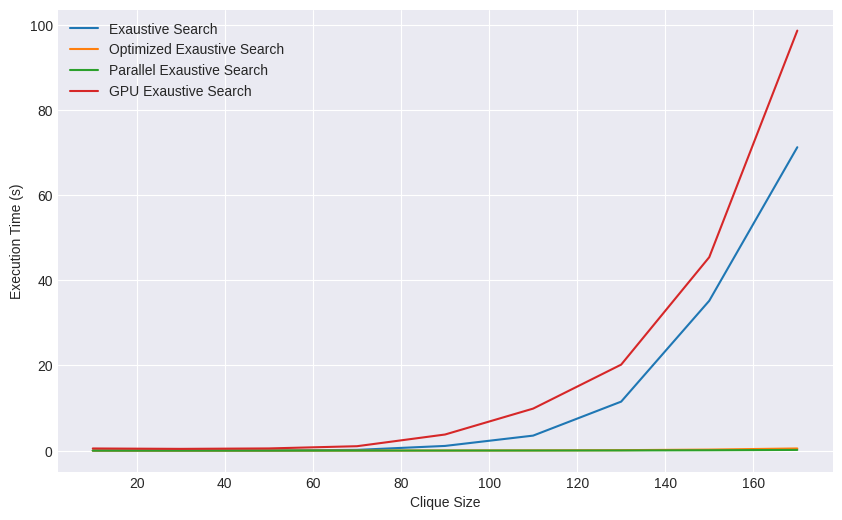

In [13]:
# Seaborn style
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(clique_size_range, exaustive_times[0], label='Exaustive Search')
plt.plot(clique_size_range, exaustive_times[1], label='Optimized Exaustive Search')
plt.plot(clique_size_range, exaustive_times[2], label='Parallel Exaustive Search')
plt.plot(clique_size_range, exaustive_times[3], label='GPU Exaustive Search')
plt.xlabel('Clique Size')
plt.ylabel('Execution Time (s)')
plt.legend()
plt.savefig("results/exaustive_search.png", dpi=300)
plt.show()

Grafo densamente conectado com 170 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 190 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 210 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 230 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 250 vertices gerado e salvo em 'grafo.txt'.


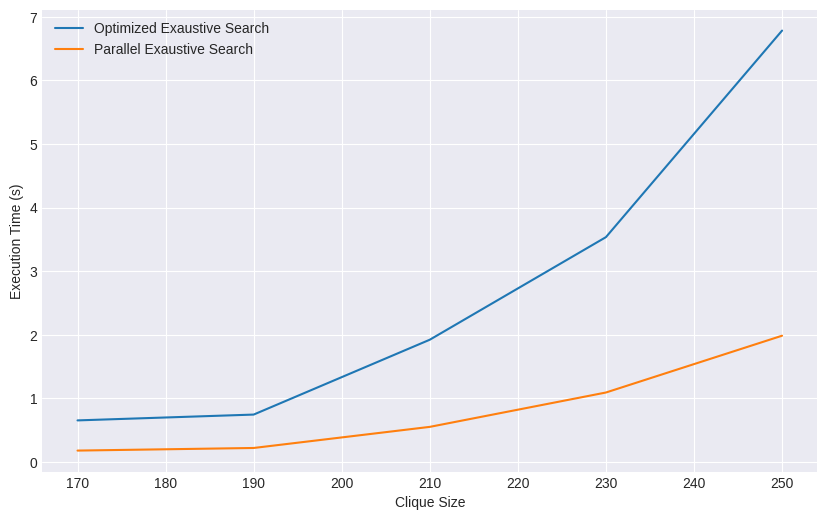

In [14]:
# Mostrando so o otimizado e o paralelo
exaustive_searchs = ['candidates_exaustive', 'exaustive_search_parallel']
exaustive_times = [[], []]
clique_size_range = range(170, 270, 20)

for size in clique_size_range:
    generate_network(size, 0.6)

    for i, exaustive_search in enumerate(exaustive_searchs):
        start_time = time.perf_counter()
        subprocess.run(['./' + exaustive_search], capture_output=True)
        end = time.perf_counter()
        exaustive_times[i].append(end - start_time)


plt.figure(figsize=(10, 6))
plt.plot(clique_size_range, exaustive_times[0], label='Optimized Exaustive Search')
plt.plot(clique_size_range, exaustive_times[1], label='Parallel Exaustive Search')
plt.xlabel('Clique Size')
plt.ylabel('Execution Time (s)')
plt.legend()
plt.savefig("results/exaustive_search_optimized_parallel.png", dpi=300)
plt.show()

## Resultados - algoritmos exaustivos

Se um resultado exato é necessário, precisamos utilizar uma busca exaustiva, mesmo que sua complexidade computacional seja grande, podemos aplicar algumas técnicas para melhorar o tempo de execução, como pudemos ver nos resultado acima, com apenas os algoritmos exatos. 

Partindo da implementação básica exponencial para o problema do Clique Máximo, podemos aplicar algumas otimizações, como foi feito do algoritmo 1 para o 2, dentre as otimizações podemos citar o backtracking (parar de calcular se a situação atual do programa não possibilitar uma solução melhor do que a já encontrada), o fato de evitar copias de dados, tirando a necessidade de retornar o clique máximo, só atribuir a uma referência o clique máximo que encontramos e filtrar apenas os vértices que são candidatos válidos, podando assim consideravelmente a árvore de recursão.

Como podemos ver, essa otimização nos dá uma vantagem bem considerável em relação à implementação mais básica, temos para 170 vértices 60 segundos na menos otimizada e aproximadamente 0.5 segundos na mais otimizada.

Em seguida, podemos que ganhamos ainda mais eficiência paralelizando nosso algoritmo com threads, tendo uma curva bem mais suave, e quanto maior o N, podemos ver que o speedup vai ficando ainda mais relevante, chegando a ser de mais de 2x para 250 vértices. 

Por fim, pudemos ver que a implementação em GPU acabou ficando bem mais lenta que as demais, acredita-se que tenha sido por conta do overhead das paralelizações, fazemos contas que nem são tão massivas (calcular os candidatos válidos) em paralelo, e temos que esperar todas as threads se jutarem logo em seguida, isto e o fator de a GPU ser mais lenta para operações sequenciais deve ter acarretado a eficiência menor da implementação com GPU em relação às outras. 

## Visualização de resultados - Heurísticas

Agora podemos comparar os resultados obtidos pelos algoritmos de heurística, comparando com uma solução exastiva, para comparar as soluções encontradas com a solução ótima.

In [15]:
heuristic_searchs = ['greedy_basic', 'greedy_degree', 'greedy_local_search']
heuristic_times = [[], [], []]
heuristic_res = [[], [], []]
validation_res = []
validation_algo = 'candidates_exaustive'
val_times = []
clique_size_range = range(10, 180, 20)
# 10, 20, 50, 70, 90, 110, 130, 150, 170
# Esses valores foram obtidos rodando o algoritmo MPI no cluster, para cada um dos tamanhos do grafo, para podermos comparar.
mpi_sizes = [2, 4, 5, 6, 7, 7, 8, 8, 8]
mpi_times = [0.0244228, 0.0310105, 0.0342154, 0.0545997, 0.0273761, 0.0498199, 0.0376388, 0.0540573, 0.0452622]

def get_found_clique_size(out, solution_line):
    lines_result = out.split('\n')
    result_size = int(lines_result[solution_line].split(':')[1].strip())
    # print(result_heuristic)
    # print(result_validation)
    return result_size

for size in clique_size_range:
    # proc = subprocess.run(['python3', 'src/python/generate_network.py', str(size)], capture_output=True, text=True)
    # print(proc.stdout)
    generate_network(size, 0.7)
    start_time = time.perf_counter()
    validation = subprocess.run(['./' + validation_algo], capture_output=True, text=True)
    end = time.perf_counter()
    size_val = get_found_clique_size(validation.stdout, 1)
    validation_res.append(size_val)
    val_times.append(end - start_time)

    for i, heuristic_search in enumerate(heuristic_searchs):
        start_time = time.perf_counter()
        out = subprocess.run(['./' + heuristic_search], capture_output=True, text=True)
        end = time.perf_counter()
        size_algo = get_found_clique_size(out.stdout, 1)
        heuristic_times[i].append(end - start_time)
        heuristic_res[i].append(size_algo)

Grafo densamente conectado com 10 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 30 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 50 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 70 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 90 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 110 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 130 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 150 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 170 vertices gerado e salvo em 'grafo.txt'.


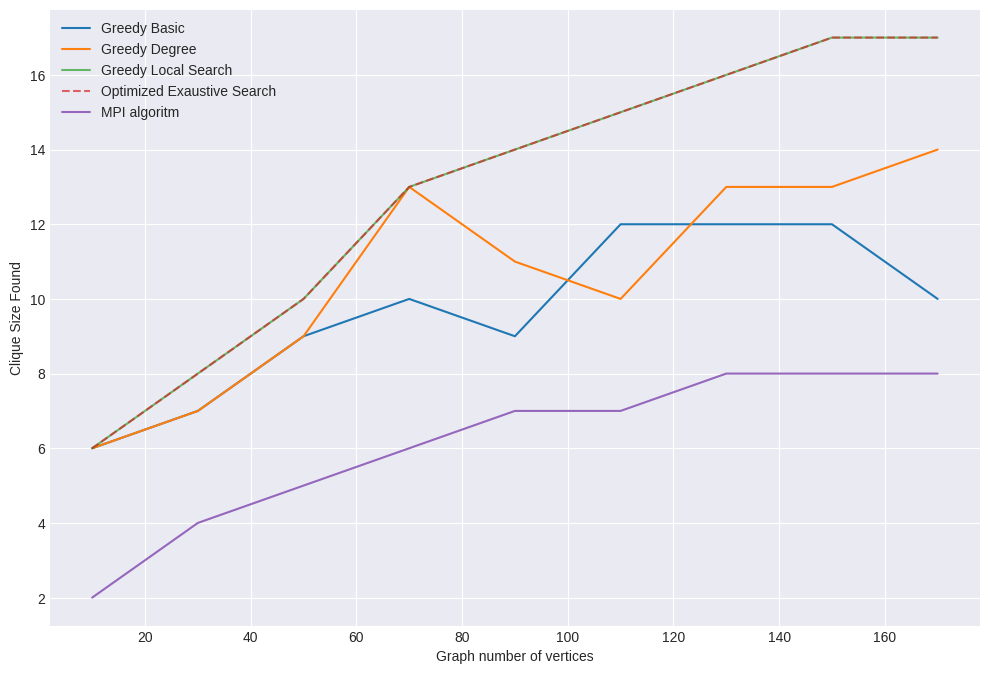

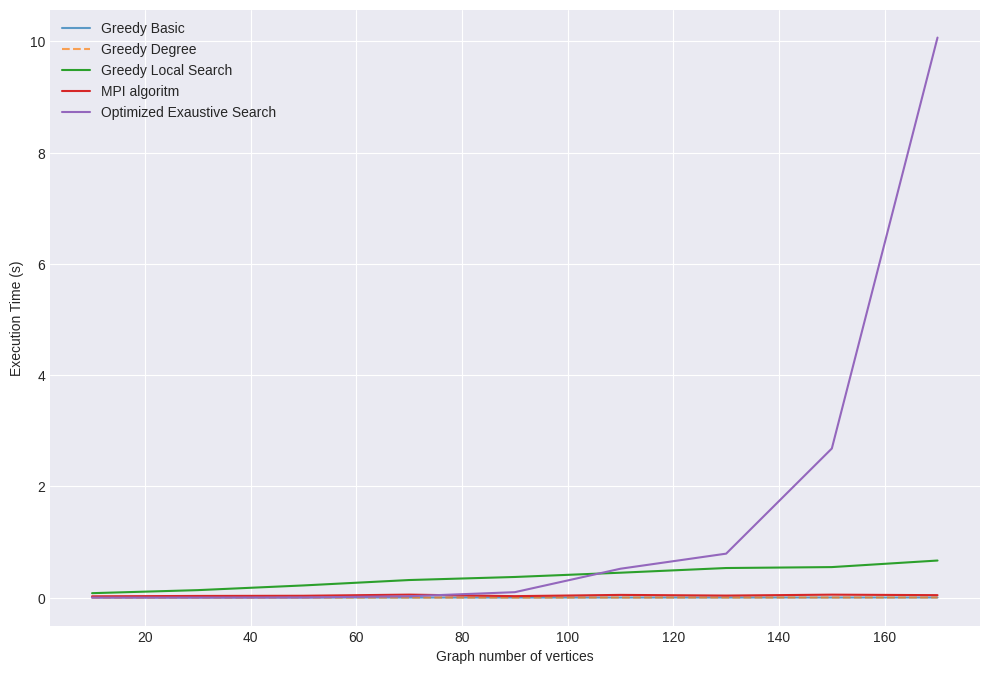

In [16]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.plot(clique_size_range, heuristic_res[0], label='Greedy Basic')
plt.plot(clique_size_range, heuristic_res[1], label='Greedy Degree')
plt.plot(clique_size_range, heuristic_res[2], label='Greedy Local Search', alpha=0.7)
plt.plot(clique_size_range, validation_res, '--', label='Optimized Exaustive Search', alpha=0.7)
plt.plot(clique_size_range, mpi_sizes, label='MPI algoritm')
plt.xlabel('Graph number of vertices')
plt.ylabel('Clique Size Found')
plt.legend()
plt.savefig("results/heuristic_clique_size_found.png", dpi=300)
plt.show()

# 1 graph to vertex size x execution time
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.plot(clique_size_range, heuristic_times[0], label='Greedy Basic', alpha=0.7)
plt.plot(clique_size_range, heuristic_times[1], '--', label='Greedy Degree', alpha=0.7)
plt.plot(clique_size_range, heuristic_times[2], label='Greedy Local Search')
plt.plot(clique_size_range, mpi_times, label='MPI algoritm')
plt.plot(clique_size_range, val_times, label='Optimized Exaustive Search')
plt.xlabel('Graph number of vertices')
plt.ylabel('Execution Time (s)')
plt.legend()
plt.savefig("results/heuristic_execution_time.png", dpi=300)
plt.show()

### Resultados - Heurísticas 1

Como pode ser visto nos gráficos acima, para um N = 100.000 na busca local(tamanho da busca local), obtivemos em quase todos os grafos a solução ótima com este algoritmo, porém com uma complexidade de tempo **polinomial**. Outra coisa que podemos notar é que o simples fato de ordenar o grafo por adjacência no `greedy Degree`, deu resultados melhores em quase todos os grafos para o algoritmo guloso.

Em termos de velocidade, temos o que é esperado, já que na busca local é necessário fazer um loop por N, e em cada uma das iterações rodar o algoritmo, é esperado que seja mais lento que apenas rodar o algoritmo guloso, como no caso do guloso básico, e do ordenado por degree.

Podemos observar também, que a abordagem semi-exaustiva com o MPI fica com uma velocidade boa, porém no final por se basear em uma hipótese um pouco ingênua (hipótese de que: podemos dividir o grafo em pedaços menores e neles achar um clique maximal grande o suficiente com busca exaustiva), acabou tendo resultados (tamanho dos cliques máximos) abaixo até das abordagens com heurística, em particular a abordagem com busca local em N grande se mostra uma boa solução para este problema, principalmente quando queremos buscar em grafos grandes.

In [17]:
# Only Greedy Local Search, Greedy Degree and MPI
# 300 400 500 600 700 800 900 1000
comparation_range = range(300, 1100, 100)
mpi_sizes_2 = [12, 13, 14, 13, 14, 15, 16, 17]
mpi_times_2 = [0.126578, 0.182503, 0.303119, 0.92072, 3.01035, 4.25436, 13.0746, 27.0991]

heuristic_times_2 = [[], []]
heuristic_res_2 = [[], []]
heuristic_searchs = ['greedy_degree', 'greedy_local_search']


for size in comparation_range:
    generate_network(size, 0.7)

    for i, heuristic_search in enumerate(heuristic_searchs):
        start_time = time.perf_counter()
        out = subprocess.run(['./' + heuristic_search], capture_output=True, text=True)
        end = time.perf_counter()
        size_algo = get_found_clique_size(out.stdout, 1)
        heuristic_times_2[i].append(end - start_time)
        heuristic_res_2[i].append(size_algo)

Grafo densamente conectado com 300 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 400 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 500 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 600 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 700 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 800 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 900 vertices gerado e salvo em 'grafo.txt'.
Grafo densamente conectado com 1000 vertices gerado e salvo em 'grafo.txt'.


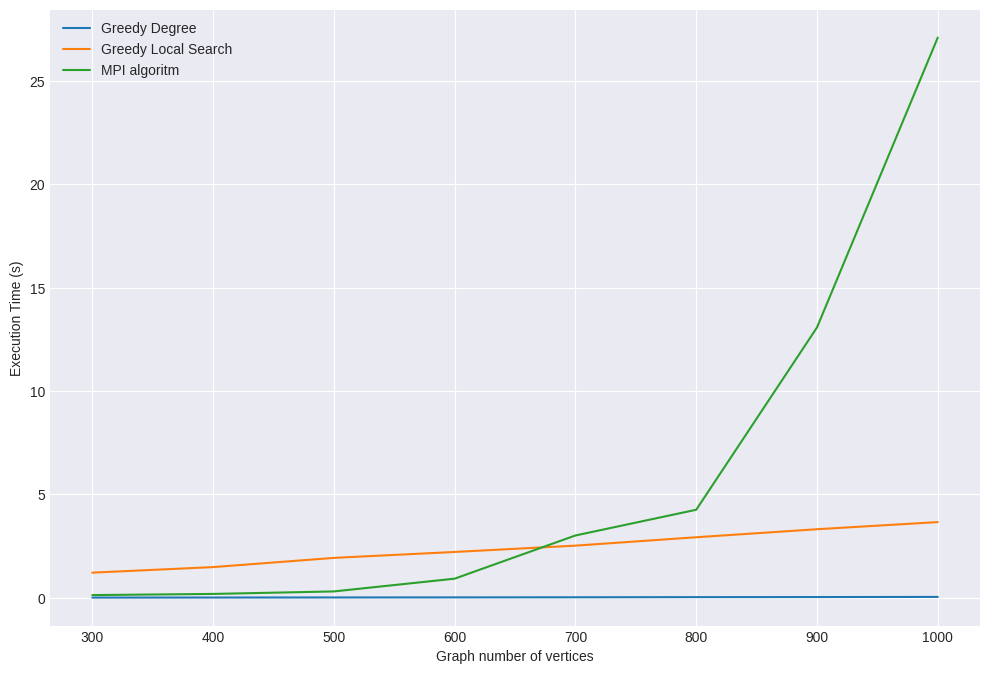

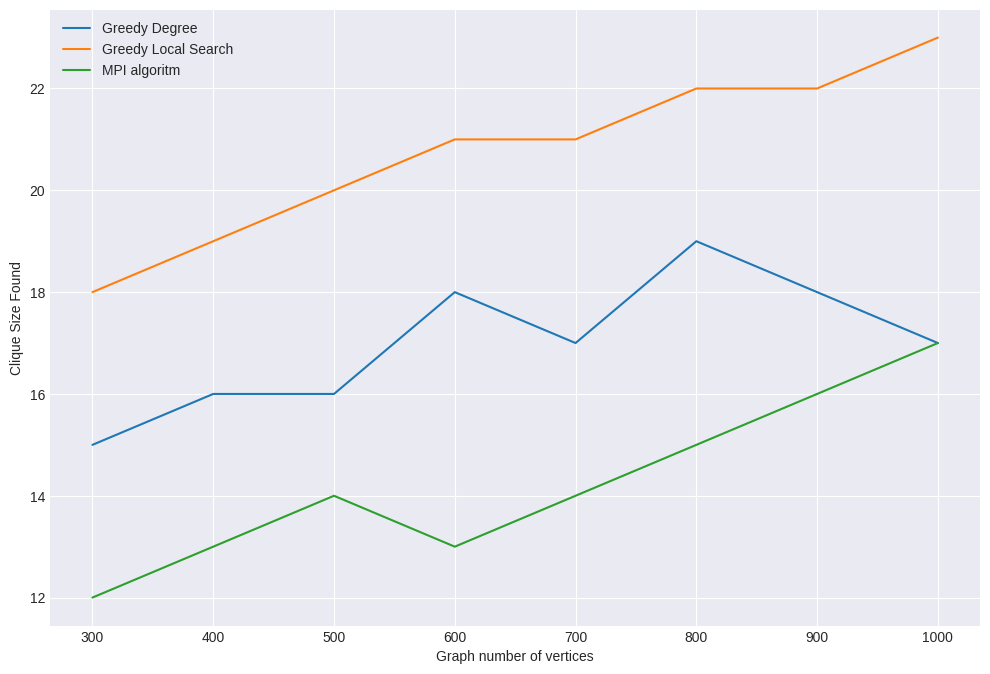

In [18]:
# Execution time vs graph size
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.plot(comparation_range, heuristic_times_2[0], label='Greedy Degree')
plt.plot(comparation_range, heuristic_times_2[1], label='Greedy Local Search')
plt.plot(comparation_range, mpi_times_2, label='MPI algoritm')
plt.xlabel('Graph number of vertices')
plt.ylabel('Execution Time (s)')
plt.legend()
plt.savefig("results/heuristic_execution_time_2.png", dpi=300)
plt.show()

# Size found vs graph size
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.plot(comparation_range, heuristic_res_2[0], label='Greedy Degree')
plt.plot(comparation_range, heuristic_res_2[1], label='Greedy Local Search')
plt.plot(comparation_range, mpi_sizes_2, label='MPI algoritm')
plt.xlabel('Graph number of vertices')
plt.ylabel('Clique Size Found')
plt.legend()
plt.savefig("results/heuristic_clique_size_found_2.png", dpi=300)
plt.show()


## Resultados - Heurísticas 2

Rodando com grafos de tamanho bem maiores, temos ainda a mesma conclusão: o algoritmo guloso normal padrão (neste caso só ordenado por degree) é o mais rápido, e a busca local é a que tem os resultados mais ótimos (não significa que é de fato um resultado ótimo)

# Conclusões


Por fim, podemos tirar algumas conclusões das muitas formas de implementação que fizemos aqui, mas em geral, se é necessário um resultado **EXATO**, precisamos de um algoritmo exaustivo, e provavelmente neste caso o ideal a seguir seria a implementação com OpenMP, e tentar chegar em ainda mais otimizações para o algoritmo, assim como otimizar ainda mais a eficácia da paralelização com threads. Chegamos à isso pois essa foi a melhor implementação exata que chegamos neste projeto.

Agora se o resultado não precisa ser **EXATO**, um resultado que seja bem próximo de ótimo é suficiente, neste caso é interessante utilizar a busca local com algoritmo guloso, pois podemos controlar o N da busca, para pegar mais ou menos opções, e para grafos maiores, ele vai continuar rodando suficientemente rápido, já que roda em tempo polinomial.

Adicionalmente, se pegarmos alguma abordagem diferente para o problema, podemos chegar em ótimas soluções com abordagens com MPI e GPU, já que cada ferramenta para paralelização performa melhor em circunstâncias diferentes.

Em síntese, como tudo na engenharia, o melhor algoritmo depende da situação, mas se temos que eleger as melhores implementações feitas neste projeto, poderíamos dizer que para tamanhos de grafo pequenos, podemos usar a `Busca exaustiva paralelizada com OpenMp`, mas se precisamos analisar grafos maiores, e a solução ótima não é obrigatória, usamos o `Algoritmo de busca local usando algoritmo guloso aleatórizado`.